In [1]:
import glob
import pickle
import pathlib
import collections
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

from enum import Enum
from tqdm import tqdm
from operator import itemgetter
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

mcolors = list(mcolors.BASE_COLORS)

In [2]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_graphs_undir = city_network_graphs.joinpath('undirected_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath('directed_graphs_betweenness')

- **d(integer)**: Straight-line distance between two stops expressed in meters.
- **duration_avg(integer)**: Travel time between stops averaged over all PT vehicles rounded to one second accuracy.
- **n_vehicles(integer)**: Number of PT vehicles that have traveled between two stops within a time interval
- **route_I_counts(list (string))**: A list of route_I's and the number of times each route has operated between two stops. For the network extracts, this data is formatted as a string where each element is written as `route_I:count` and different routes are separated by a comma. An example value for this field is thus `1:3,2:131,10:93`. Please note that the definition of a route varies across the cities provided, and that routes can have deviations from their main paths for instance when traveling to and from a depot.
- **route_I(integer)**: Identifier for a route.

Below is a table extracted from the [Data Paper](https://www.nature.com/articles/sdata201889) about the types of routes.

<img src="./../../data/images/about_transport_data/route-types.png" alt="Route Types" width="60%" title="route-types"/>


## Utility Functions


In [3]:
# Define enum for route types
class RouteType(Enum):
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

In [4]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)
# cities_graphs_undir = load_all_cities_graphs(cities, city_network_graphs_undir)

In [5]:
cities_routes = {}
for city, city_graphs in cities_graphs_dir.items():
    routes_ = []
    for route_type, route_graph in city_graphs.items():
        if ((route_type in ['full']) or (route_graph is None)):
            continue
        routes_.append(RouteType[route_type].name)
    cities_routes[city] = len(routes_)

## Serving Routes for each node

In [6]:
intermode_attrs_cities = {}
for city_name, city_graphs in tqdm(cities_graphs_dir.items()):

    node_attrs = {}
    city_full_graph = city_graphs['full']
    
    edges_unq = []

    for edge in city_full_graph.edges():
        if edge not in edges_unq:
            edges_unq.append(edge)
            
    for node1, node2 in edges_unq:        
        edge_data = city_full_graph.get_edge_data(node1, node2)
        
        if node1 not in node_attrs:
            node_attrs[node1] = {"in_route_type": [], "out_route_type": []}
        
        if node2 not in node_attrs:
            node_attrs[node2] = {"in_route_type": [], "out_route_type": []}

        for edge_info in edge_data.values():
            route_id = edge_info['route_type']
            if route_id not in node_attrs[node1]['out_route_type']:
                node_attrs[node1]['out_route_type'].append(route_id)
            
            if route_id not in node_attrs[node2]['in_route_type']:
                node_attrs[node2]['in_route_type'].append(route_id)
                
    city_name_ = city_name.title() + ' ({})'.format(cities_routes[city_name])
    intermode_attrs_cities[city_name_] = node_attrs

100%|██████████| 25/25 [00:10<00:00,  2.28it/s]


In [7]:
cities_graphs_modes_df = pd.DataFrame.from_dict({(i,j): intermode_attrs_cities[i][j]
                       for i in intermode_attrs_cities.keys() 
                       for j in intermode_attrs_cities[i].keys()},
                   orient='index').reset_index(drop=False, names=['city', 'node_id'])
cities_graphs_modes_df['in_type_count'] = cities_graphs_modes_df["in_route_type"].str.len()
cities_graphs_modes_df['out_type_count'] = cities_graphs_modes_df["out_route_type"].str.len()
cities_graphs_modes_df['all_type_count'] = [len(set(a).union(b)) for a, b in zip(cities_graphs_modes_df["in_route_type"], cities_graphs_modes_df["out_route_type"])]

cities_graphs_modes_df['size'] = cities_graphs_modes_df.groupby(["city", "in_type_count", "out_type_count"])["node_id"].transform("size")
# cities_graphs_modes_df = cities_graphs_modes_df.drop_duplicates(subset=["city", "in_type_count", "out_type_count", "size"])
cities_graphs_modes_df['size1'] = cities_graphs_modes_df.groupby(["city"])["size"].transform(lambda x: x*100/x.sum())


cities_graphs_modes_df

,city,node_id,in_route_type,out_route_type,in_type_count,out_type_count,all_type_count,size,size1
0,Adelaide (3),1.0,[2],[2],1,1,1,7287,0.013723
1,Adelaide (3),2.0,[2],[2],1,1,1,7287,0.013723
2,Adelaide (3),3.0,[2],[2],1,1,1,7287,0.013723
3,Adelaide (3),8.0,[2],[2],1,1,1,7287,0.013723
4,Adelaide (3),4.0,[2],[2],1,1,1,7287,0.013723
...,...,...,...,...,...,...,...,...,...
102653,Winnipeg (1),5040.0,[3],[3],1,1,1,5057,0.019775
102654,Winnipeg (1),5054.0,[3],[3],1,1,1,5057,0.019775
102655,Winnipeg (1),5084.0,[3],[3],1,1,1,5057,0.019775
102656,Winnipeg (1),5083.0,[3],[3],1,1,1,5057,0.019775


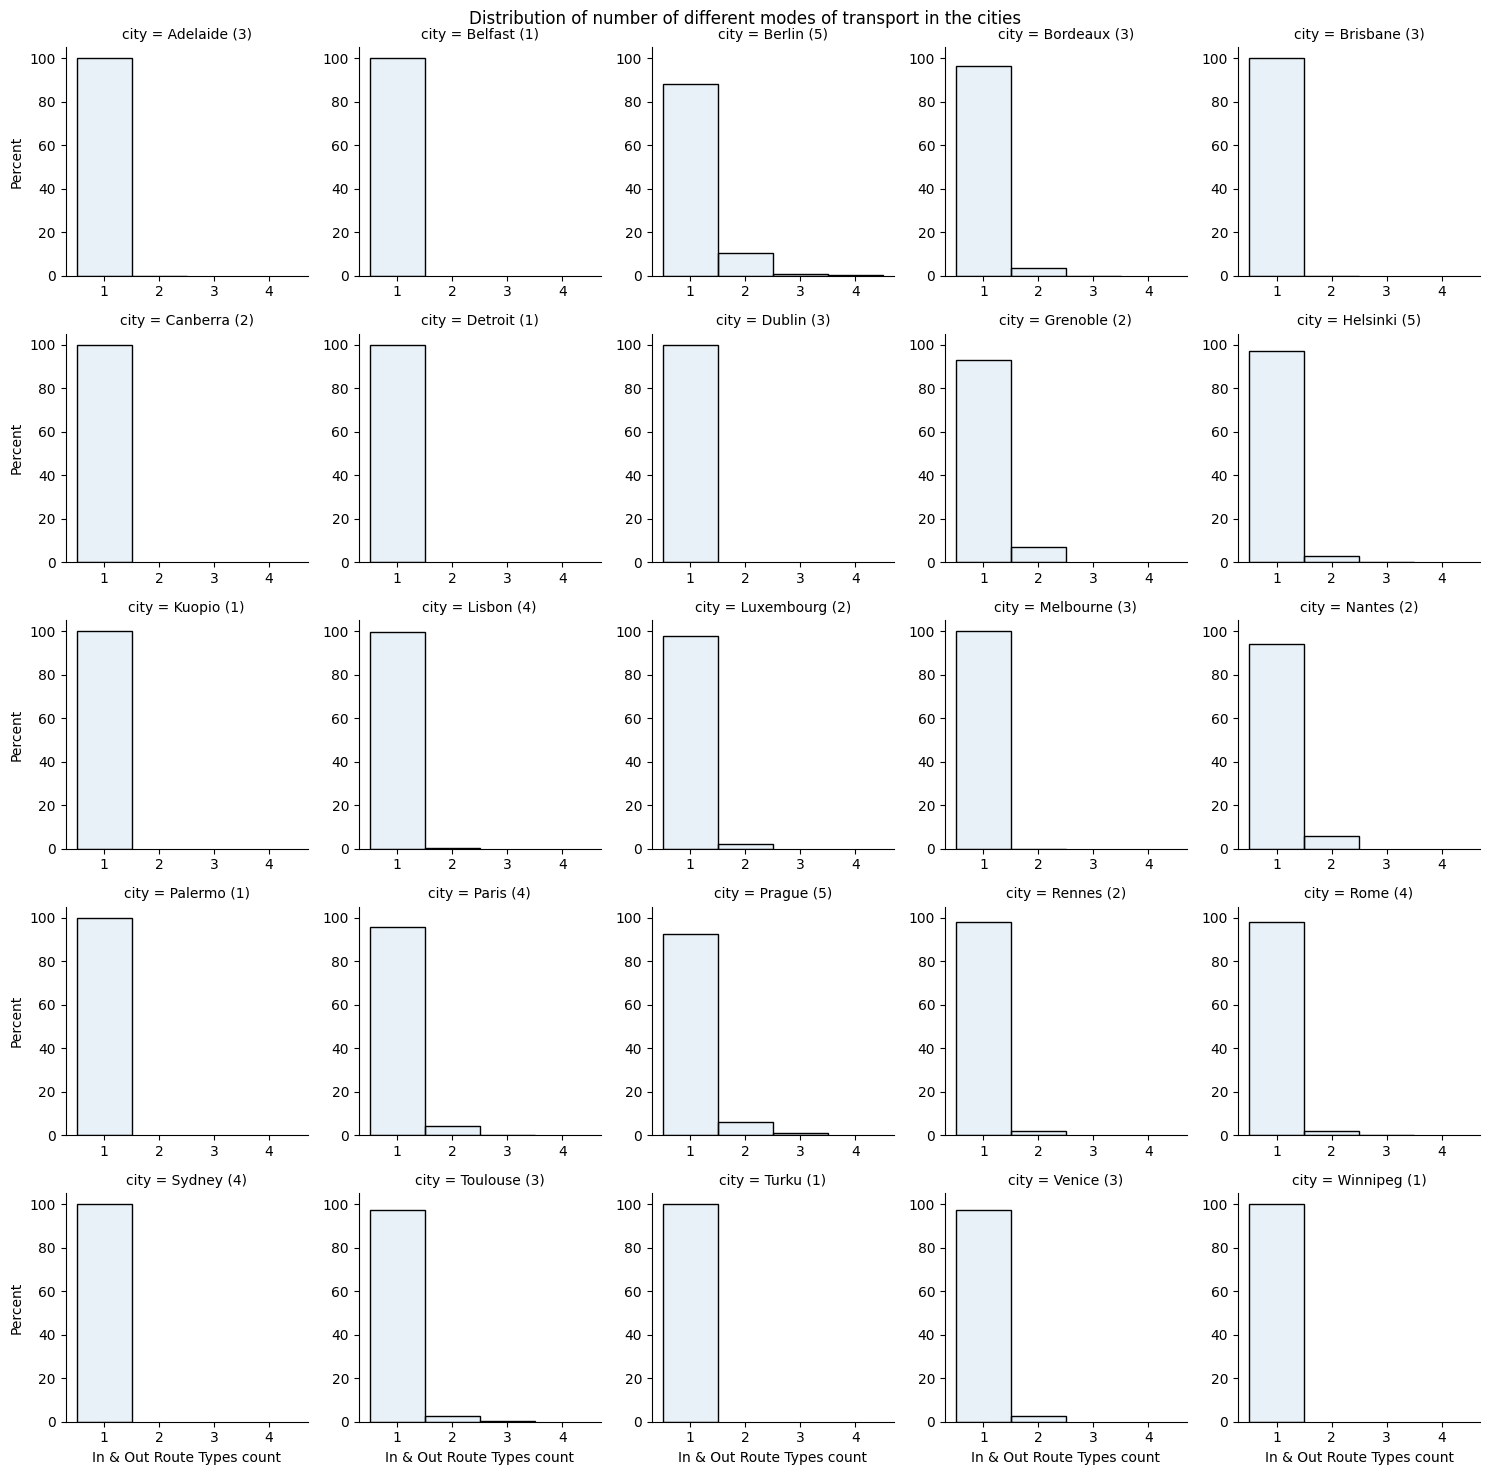

In [19]:
g = sns.FacetGrid(cities_graphs_modes_df, col="city", col_wrap=5)
# g.map(sns.histplot, "in_type_count", color="y", discrete=True, alpha=0.5).set(yscale = 'log')
# g.map(sns.histplot, "out_type_count", color="b", discrete=True, alpha=0.3).set(yscale = 'log')
g.map(sns.histplot, "all_type_count", stat="percent", discrete=True, alpha=0.1)
for ax in g.axes.flat:
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)
    # ax.yaxis.get_major_locator().set_params(integer=True)
g.set_axis_labels("In & Out Route Types count")
g.fig.suptitle("Distribution of number of different modes of transport in the cities")
plt.tight_layout()

The plot above displays the relationship between the number of modes of transport and the number of nodes in a city. A city is considered well-connected if there are more opportunities to switch between different modes of transport. In other words, a higher number of nodes with multiple transportation options passing through them indicates a well-connected transport network. However, this analysis does not fully apply to cities like Belfast, Detroit, Kuopio, Palermo, Turku, and Winnipeg, as they only have bus transport. For most cities, the distribution is skewed to the left, suggesting that the majority of nodes accommodate only one mode of transport. These cities have less interconnected transport networks, resulting in congestion at central stations where many people need to switch vehicles. Adelaide, Brisbane, Canberra, Dublin, and Sydney belong to this category, although Adelaide and Sydney have three and four modes of transport respectively. The second category comprises cities with moderately connected networks, such as Bordeaux, Helsinki, Lisbon, Melbourne, Paris, and Rome. In these cities, a relatively higher number of nodes are connected to more than one or two modes of transport. Lastly, the well-connected cities include Berlin, Grenoble, Luxembourg, Nantes, Prague, Rennes, Toulouse, and Venice. These cities have a larger proportion of nodes connected to diverse sets of transportation modes. This allows passengers to disperse across multiple stations, facilitating ease of movement. It's important to note that this analysis solely focuses on theoretical connectivity and does not account for factors like city area, population, or topography.